# Using NOAA Covariates in NEON timeseries forecasting

Let's start by getting some NOAA data, as in [Carl's example](https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&bypass_fastly=true&color_mode=light&commit=7c8271523b94bfd48c7fbd7810f1a8f818e8ad42&device=unknown_device&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f65636f34636173742f6e656f6e34636173742d7475746f7269616c732f376338323731353233623934626664343863376662643738313066316138663831386538616434322f707974686f6e2d4546492d636c6f75642d646174612e6970796e62&logged_in=true&nwo=eco4cast%2Fneon4cast-tutorials&path=python-EFI-cloud-data.ipynb&platform=mac&repository_id=616688022&repository_type=Repository&version=111)

## NOAA data juggling

Data have the resolution of hours and they're a pretty big dataset, so in this section we pretty much restrict it down to what is actually useful to us.

In [2]:
import polars as pl
import pyarrow.dataset as ds
from pyarrow import fs
import pandas as pd
from datetime import date

from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.metrics import mse
from darts.models import TCNModel, CatBoostModel, NBEATSModel, NLinearModel, RNNModel

from pytorch_lightning.callbacks import Callback
import torch

from pytorch_lightning.callbacks import Callback, EarlyStopping
from optuna.integration import PyTorchLightningPruningCallback
import optuna

import json

In [3]:
from datetime import date, timedelta

def NOAA_forecast_scan(date_used: date, site_id:str = "TREE", variable:str = "TMP"):
    s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
    path = f"neon4cast-drivers/noaa/gefs-v12/stage1/0/{date_used.isoformat()}"
    dataset = ds.dataset(path, filesystem=s3)
    return (
        pl.scan_pyarrow_dataset(dataset)
        .filter(pl.col("site_id") == site_id)
        .filter(
          (pl.col("variable") == variable)
        )
        .collect()
        .pivot(index = "datetime", columns = "variable", values = "prediction")
    )

def NOAA_stage3_scan(site_id:str = "TREE", variable:str = "TMP"):
    s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
    path = "neon4cast-drivers/noaa/gefs-v12/stage3/parquet"
    dataset = ds.dataset(path, filesystem=s3)
    return (
        pl.scan_pyarrow_dataset(dataset)
        .filter(pl.col("site_id") == site_id)
        .filter(
          (pl.col("variable") == variable)
        )
        .collect()
        .pivot(index = "datetime", columns = "variable", values = "prediction")
    )

In [4]:
def day_mean(df, var_to_avg = "TMP", time_col = "datetime", avg_name = "TMP_day_avg"):
    """
    averages values of the column given over the course of a day
    """
    return (
        df
        .with_columns(pl.col(time_col).cast(pl.Date).alias("date"))
        .groupby("date")
        .agg(
            [
                pl.col(var_to_avg).mean().alias(avg_name)
            ]
        )
        .sort("date")
    )

def day_mean_several(df, var_names, time_col = "datetime", avg_name_app = "day_avg"):
    """
    averages values of the column given over the course of a day
    """
    return (
        df
        .with_columns(pl.col(time_col).cast(pl.Date).alias("date"))
        .groupby("date")
        .agg(
            [
                pl.col(var).mean().alias("_".join([var,avg_name_app])) for var in var_names
            ]
        )
        .sort("date")
    )

df = day_mean(NOAA_forecast_scan(date.today()-timedelta(days = 1)))

# df.head(10)

In [5]:
def pl_to_series(df, time_col = "date", freq = "D"):
    """
    input: polars dataframe
    output: corresponding darts.TimeSeries
    
    for now the easiest thing is to use pandas as a middle-man.
    """
    pd_df = df.to_pandas()
    pd_df["date"] = pd.to_datetime(pd_df["date"])
    return (
        TimeSeries.from_dataframe(
            pd_df,
            time_col = time_col,
            freq = freq,
        )
    )

In [76]:
# series = pl_to_series(df)
# series.plot()

In [77]:
# noaa_future_cov = series

## NOAA Stage 3 (historic data)

In [81]:
# stage3_series = pl_to_series(NOAA_stage3_scan())
#
# -> errors, I'll pop open the functions and see whats up

# stage3 = NOAA_stage3_scan()

In [7]:
s3 = fs.S3FileSystem(endpoint_override = "data.ecoforecast.org", anonymous = True)
path = f"neon4cast-drivers/noaa/gefs-v12/stage3/parquet/"
dataset = ds.dataset(path, filesystem=s3, partitioning=["site_id"])
historic_noaa_full = pl.scan_pyarrow_dataset(dataset) 

### Specializes to a given site

In [8]:
site_id = "WOOD"

historic_noaa = (
    historic_noaa_full
    .filter(pl.col("site_id") == site_id)
    .collect()
    .pivot(index = "datetime", columns = "variable", values = "prediction")
)

### Thin out columns and take daily mean

In [9]:
# thin out
historic_noaa = historic_noaa[["datetime", "air_temperature", "air_pressure", "precipitation_flux", "relative_humidity"]]
historic_noaa_daily = day_mean_several(
    historic_noaa, 
    ["air_temperature", "air_pressure", "precipitation_flux", "relative_humidity"]
)

In [79]:
historic_noaa_daily.columns = ["date", "tmp_avg", "pressure_avg", "precip_flux_avg", "rel_humidity_avg"]
# historic_noaa_daily.head()

In [11]:
noaa_covariates = pl_to_series(historic_noaa_daily)

# Use NOAA as covariates

Now that I set up NOAA 1-day predictions as a darts TimeSeries, I can use them as a covariate. Let's see how it goes!

In [12]:
def fit_the_model(model_class, train, joint_kwargs = {}):
    # initial data preprocessing
    model_kwargs = joint_kwargs.get("model_kwargs", {})
    fit_kwargs = joint_kwargs.get("fit_kwargs", {})
    
    # model creation and fit
    model = model_class(**model_kwargs)
    model.fit(train, **fit_kwargs)
    
    return model

def forecast(model_class, series, frac = 0.75, joint_kwargs = {}):
    train, val = series.split_before(frac)
    fit_model = fit_the_model(model_class, train, joint_kwargs)
    return val, model.predict(len(val))

## Getting the NEON data

In [74]:
def read_neon(
    site_id, 
    time_col = "datetime", 
    freq = "D", 
    link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz",
    raw_columns_of_interest = "variable",
    variables_of_interest = ["abundance", "richness"],
    fill = "auto",
):
    site_data = pd.read_csv(link)
    site_data["datetime"] = pd.to_datetime(site_data["datetime"]).dt.tz_localize(None)
    site_data = (
        site_data
        .loc[site_data["site_id"] == site_id]
        .pivot(index="datetime", columns=raw_columns_of_interest, values="observation")
    )
    site_data.columns = variables_of_interest
    return fill_missing_values(
        TimeSeries.from_dataframe(
            site_data,
            freq = freq,
        ),
        fill = fill,
    )

def read_neon_day_avg(
    site_id, 
    time_col = "datetime", 
    link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz",
    raw_columns_of_interest = "variable",
    variables_of_interest = ["abundance", "richness"],
    fill = "auto",
):
    site_data = pd.read_csv(link)
    site_data["datetime"] = pd.to_datetime(site_data["datetime"]).dt.tz_localize(None)
    site_data = (
        site_data
        .loc[site_data["site_id"] == site_id]
        .pivot(index="datetime", columns=raw_columns_of_interest, values="observation")
    )
    site_data = (
        day_mean_several(
            pl.from_pandas(site_data), 
            var_names=variables_of_interest, 
            time_col = "datetime", 
            avg_name_app = "day_avg"
        )
    )
    site_data.columns = variables_of_interest
    
    return fill_missing_values(
        TimeSeries.from_dataframe(
            site_data,
            freq = "D",
        ),
        fill = fill,
    )

def inspect_variables(
    link,
    var_col_names = ["variable"],
):
    site_data = pd.read_csv(link)
    print(f"inspect_variables: FYI, the columns are {site_data.columns}")
    return (
        {
            var: f"{site_data[var].unique()}".replace("\n","") for var in var_col_names
        }
    )

In [14]:
aquatic_link = "https://data.ecoforecast.org/neon4cast-targets/aquatics/aquatics-expanded-observations.csv.gz"
terrestrial_link = "https://data.ecoforecast.org/neon4cast-targets/terrestrial_30min/terrestrial_30min-targets.csv.gz"
tick_link = "https://data.ecoforecast.org/neon4cast-targets/ticks/ticks-targets.csv.gz"
phenology_link = "https://data.ecoforecast.org/neon4cast-targets/phenology/phenology-targets.csv.gz"
beetle_link = "https://data.ecoforecast.org/neon4cast-targets/beetles/beetles-targets.csv.gz"

print(
    json.dumps(
        inspect_variables(
            phenology_link, 
            var_col_names = ["variable", "site_id"]
        ),
        indent = 2,
    )
)

inspect_variables: FYI, the columns are Index(['datetime', 'site_id', 'variable', 'observation'], dtype='object')
{
  "variable": "['gcc_90' 'rcc_90']",
  "site_id": "['ABBY' 'BARR' 'BART' 'BLAN' 'BONA' 'CLBJ' 'CPER' 'DCFS' 'DEJU' 'DELA' 'DSNY' 'GRSM' 'GUAN' 'HARV' 'HEAL' 'JERC' 'JORN' 'KONA' 'KONZ' 'LAJA' 'LENO' 'MLBS' 'MOAB' 'NIWO' 'NOGP' 'OAES' 'ONAQ' 'ORNL' 'OSBS' 'PUUM' 'RMNP' 'SCBI' 'SERC' 'SJER' 'SOAP' 'SRER' 'STEI' 'STER' 'TALL' 'TEAK' 'TOOL' 'TREE' 'UKFS' 'UNDE' 'WOOD' 'WREF' 'YELL']"
}


In [33]:
site_data = pd.read_csv(terrestrial_link)
site_data["datetime"] = pd.to_datetime(site_data["datetime"]).dt.tz_localize(None)
site_data = (
    site_data
    .loc[site_data["site_id"] == "WOOD"]
    .pivot(index="datetime", columns="variable", values="observation")
)
site_data.head(20)

variable,le,nee
datetime,,
2017-02-01 10:00:00,NaN,NaN
2017-02-01 10:30:00,NaN,NaN
2017-02-01 11:00:00,NaN,NaN
2017-02-01 11:30:00,NaN,NaN
2017-02-01 12:00:00,NaN,NaN
2017-02-01 12:30:00,NaN,NaN
2017-02-01 13:00:00,NaN,NaN
2017-02-01 13:30:00,NaN,NaN
2017-02-01 14:00:00,NaN,NaN


In [68]:
import math
site_data_not_null = site_data.dropna()

In [70]:
site_data_not_null.head(20)

variable,le,nee
datetime,,
2017-09-07 17:00:00,147.654332,-2.581899
2017-09-07 17:30:00,115.460335,-1.757220
2017-09-07 18:00:00,121.265569,-1.422032
2017-09-07 18:30:00,145.250684,-1.251686
2017-09-07 19:00:00,116.533654,-1.114051
2017-09-07 19:30:00,141.017200,-1.305168
2017-09-07 20:00:00,109.875558,-1.293743
2017-09-07 20:30:00,94.049697,-0.895565
2017-09-07 21:00:00,132.989533,-2.128531


In [75]:
terr = read_neon_day_avg(
    site_id = "WOOD",
    link = terrestrial_link,
    variables_of_interest = ["nee", "le"],
)

ColumnNotFoundError: nee

Error originated just after this operation:
DF ["datetime", "site_id", "variable", "observation"]; PROJECT */5 COLUMNS; SELECTION: "None"

In [15]:
# sites WOOD, WREF, and YELL have terrestrial, phenology and beetles

# terrestrial data
terr = read_neon(
    site_id = "WOOD",
    link = terrestrial_link,
    freq = "min",
    variables_of_interest = ["nee", "le"],
)

phen = read_neon(
    site_id = "WOOD",
    link = phenology_link,
    freq = "min",
    variables_of_interest = ['gcc_90', 'rcc_90'],
)

beet = read_neon(
    site_id = "WOOD",
    link = beetle_link,
    freq = "min",
    variables_of_interest = ["abundance", "richness"],
)

## Setting series to start at same date as NOAA

2020-10-01

And actually no beetles at all cause their timeseries ends too soon.

In [16]:
preterr, terr = terr.split_before(pd.Timestamp('2020-10-01 00:00:00', tz=None))
prephen, phen = phen.split_before(pd.Timestamp('2020-10-01 00:00:00', tz=None))
# prebeet, beet = beet.split_before(pd.Timestamp('2020-10-01 00:00:00', tz=None))

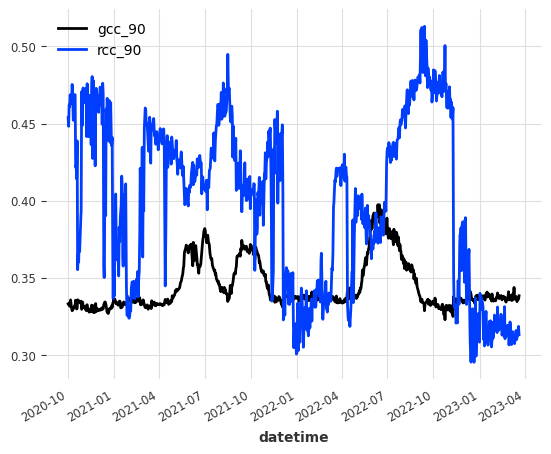

In [17]:
phen.plot()

In [17]:
terr_train, terr_validate = terr.split_before(pd.Timestamp('2023-02-01 00:00:00', tz=None))
phen_train, phen_validate = phen.split_before(pd.Timestamp('2023-02-01 00:00:00', tz=None))
noaa_past_covariates, noaa_future_covariates = (
    noaa_covariates.split_before(pd.Timestamp("2023-02-01"))
)

## CatBoost Model

In [28]:
# gpu_id = 0 # 0 or 1
# pl_trainer_kwargs = {
#     "accelerator": "gpu",
#     "devices": [gpu_id],
#     "callbacks": callbacks,
# }
# num_workers = 4

meow = CatBoostModel(
    lags = 356,
    lags_past_covariates = 30,
    # lags_future_covariates = [20],
    output_chunk_length = 30,
    multi_models = True,
    task_type = "GPU",
    devices = "0",
)

In [29]:
# pre_noaa, unde_short = unde_series.split_before(pd.Timestamp('2020-11-01 00:00:00', tz=None))

# unde_short_train, unde_short_val = unde_short.split_before(0.6)
# unde_short_train.plot()
# unde_short_val.plot()

# unde_train, unde_val = unde_series.split_before(0.85)
# unde_train

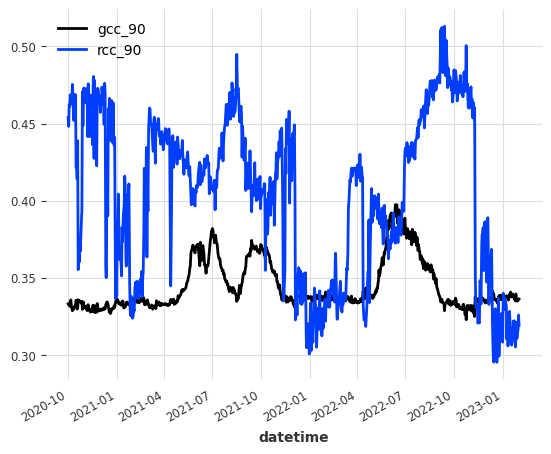

In [27]:
phen_train.plot()

In [30]:
meow.fit(
    series = terr_train,
    past_covariates = phen_train,
    # future_covariates = noaa_future_covariates,
)

/home/rstudio/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/home/rstudio/.local/lib/python3.10/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


In [1]:
terr_forecast = meow.predict(len(terr_val))

NameError: name 'meow' is not defined

## N-BEATS Model


In [19]:
callbacks = [EarlyStopping("train_loss", min_delta=0.0001, patience=5, verbose=True)]

badum = NBEATSModel(
    input_chunk_length = 356,
    output_chunk_length = 30,
    pl_trainer_kwargs = {
        "accelerator": "gpu",
        "devices": [0],
        "callbacks": callbacks,
    }
)

/home/rstudio/.local/lib/python3.10/site-packages/torch/random.py:107: UserWarning: CUDA reports that you have 2 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


In [ ]:
badum.fit(
    series = terr_train,
    past_covariates = phen_train,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 17.2 M
---------------------------------------------------
17.2 M    Trainable params
9.8 K     Non-trainable params
17.2 M    Total params
68.881    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [ ]:
terr_forecast = badum.predict(len(terr_val))

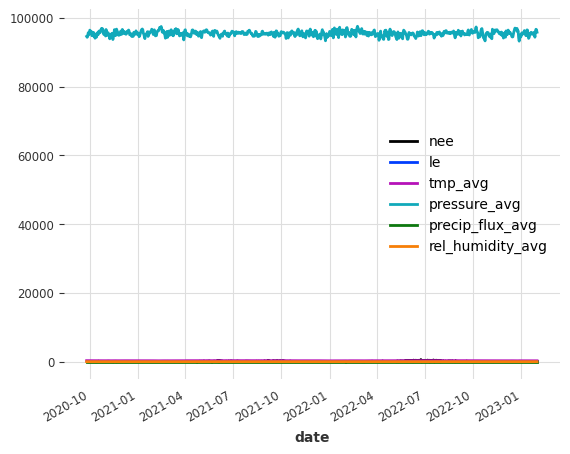

In [25]:
terr_train.plot()
noaa_past_covariates.plot()

In [31]:
# badum.predict(len(terr_validate)).plot()
terr_validate["component"]

KeyError: "not all values found in index 'component'"